# LDA

In [1]:
import pandas as pd
import numpy as np

In [2]:
from sklearn.feature_extraction.text import CountVectorizer
from gensim import corpora
from gensim.models import LdaModel
import pyLDAvis
import pyLDAvis.gensim
import os
import pickle


In [3]:
pwd

'/Users/gytkd/Desktop/Backup-Thesis/scripts/mpib/finalized-modeling'

## Demographic data calling

In [4]:
# call the original data again
df = pd.read_csv('/Users/gytkd/Desktop/Backup-Thesis/data/processed_data/reference_dataset_v1.csv')

In [5]:
df.head(3)

,Unnamed: 0,problem_id,participant_id,DAT,CRT2,CURIOSITY_SCORE,AGE,GENDER,EDUCATION,EMPLOYMENT,...,POLITICAL,CLIMATE,COVID,NEWS,MEDIA,RELATION_KNOWLEDGE,RELATION_INTEREST,RELATION_CONCERN,ideas,emb_ideas
0,0,Q1,00278,74.104969,3,4.229167,24,1,5,1,...,2,1,1,4,5,2,4,4,"['vaccination schemes in these areas', 'increa...","[[-0.011656875722110271, -0.019422005861997604..."
1,1,Q2,00278,74.104969,3,4.229167,24,1,5,1,...,2,1,1,4,5,3,5,5,['equal pay for women and men in the same role...,"[[-0.0034376916009932756, 0.006209875456988811..."
2,2,Q3,00278,74.104969,3,4.229167,24,1,5,1,...,2,1,1,4,5,3,5,5,"['look into conservation plans ', 'ensure poac...","[[0.03516001999378204, -0.004544570576399565, ..."


In [6]:
df = df.rename(columns = {'participant_id': 'PARTICIPANT_ID'})
df = df.set_index('PARTICIPANT_ID')

In [7]:
demos = df[['AGE', 'GENDER', 'EDUCATION', 'EMPLOYMENT', 'INCOME', 'POLITICAL', 'DAT', 'CRT2']]

In [8]:
# Check for duplicate indices
duplicates = demos.index.duplicated()

# keep only the first occurrence of each participant_id (remove duplicates)
demos.drop_duplicates(keep='first', inplace=True)

# Display the modified DataFrame
print("\nDataFrame with unique participant_id:")
print(demos)


DataFrame with unique participant_id:
                AGE  GENDER  EDUCATION  EMPLOYMENT  INCOME  POLITICAL  \
PARTICIPANT_ID                                                          
00278            24       1          5           1       3          2   
0068d            74       1          2           7       2          4   
00f13            43       1          4           1       3          3   
01cb6            56       3          2           8       1          1   
02670            25       1          5           1       2          2   
...             ...     ...        ...         ...     ...        ...   
f92a4            35       1          5           1       3          3   
f9fd8            50       1          4           8       2          2   
fb2a2            38       1          2           8       1          3   
fb9c4            21       1          4           8       3          2   
ff2bf            67       1          2           7       2          4   

           

/var/folders/j0/9xtsbl9502ng_j6cfbbp6fq00000gn/T/ipykernel_16675/256376826.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  demos.drop_duplicates(keep='first', inplace=True)


## Dataset: Question 2


In [9]:
q2 = pd.read_json('/Users/gytkd/Desktop/Backup-Thesis/data/processed_data/knowledge_q2_lemmatized.jsonl', orient='records', lines = True)

In [10]:
q2 = q2.groupby('participant_id')['answer'].apply(lambda x: ' '.join(x)).reset_index()
q2.fillna('', inplace=True)

In [11]:
q2.head()

,participant_id,answer
0,00278,equal pay woman men role ensure woman voice he...
1,0068d,ensure equal salary paid people regardless sex...
2,00f13,ensuring equal pay ensuring fair 5050 split me...
3,01cb6,employ equal number target desired gender impr...
4,02670,hire woman nonbinary people organise programme...


In [12]:
index_save = q2['participant_id']

In [13]:
# Step 4: Vectorize the concatenated responses using BoW
vectorizer = CountVectorizer(max_features=1000)
vectors2 = vectorizer.fit_transform(q2['answer']).toarray()

In [14]:
# Step 5: Create a DataFrame from the vectors
final_df = pd.DataFrame(vectors2, index=q2['participant_id'])

In [15]:
# Step 6: Convert final_df to a Gensim-compatible corpus format
corpus = [list(enumerate(doc)) for doc in final_df.values]

# Create a Gensim Dictionary using the vocabulary from the vectorizer
vocab = vectorizer.get_feature_names_out()
dummy_dict = corpora.Dictionary()
dummy_dict.token2id = {word: idx for idx, word in enumerate(vocab)}
dummy_dict.id2token = {idx: word for idx, word in enumerate(vocab)}

## Coherence Score to define num_topics parameter

In [16]:
from gensim.models import CoherenceModel

### warning: it takes long. Make sure it is needed.

In [235]:
# # Function to compute coherence score
# def compute_coherence_score(corpus, dictionary, texts, num_topics):
#     lda_model = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary, passes=10)
#     coherence_model = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
#     return coherence_model.get_coherence()

# # Prepare texts for coherence computation
# texts = [doc.split() for doc in q2['answer']]  # Assuming you have preprocessed texts

# # Evaluate coherence score for different numbers of topics
# num_topics_list = range(2, 11)
# coherence_scores = []

# for num_topics in num_topics_list:
#     coherence_score = compute_coherence_score(corpus, dummy_dict, texts, num_topics)
#     coherence_scores.append(coherence_score)
#     print(f'Number of topics: {num_topics}, Coherence Score: {coherence_score}')

Number of topics: 2, Coherence Score: 0.27435127056864994
Number of topics: 3, Coherence Score: 0.31090839365576306
Number of topics: 4, Coherence Score: 0.25239989237944416
Number of topics: 5, Coherence Score: 0.28214300982840884
Number of topics: 6, Coherence Score: 0.2737650485957836
Number of topics: 7, Coherence Score: 0.25451981697887255
Number of topics: 8, Coherence Score: 0.27775930745763044
Number of topics: 9, Coherence Score: 0.26138033472273536
Number of topics: 10, Coherence Score: 0.26354256273388554


In [236]:
import matplotlib.pyplot as plt

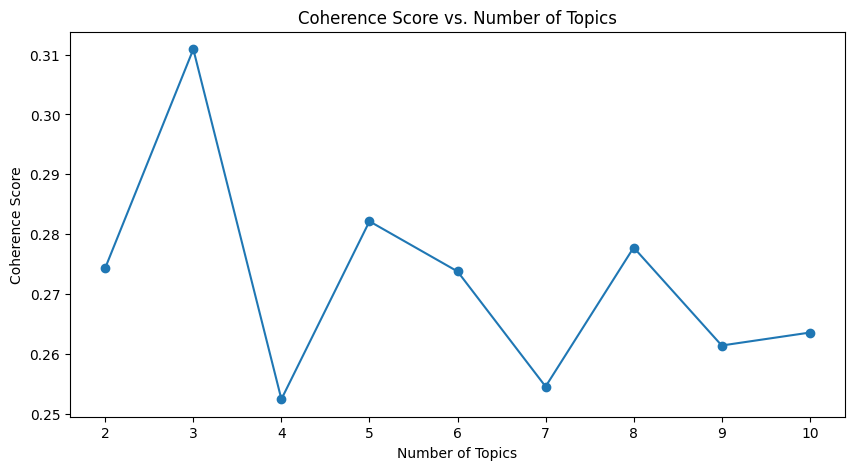

In [237]:
# # Plot coherence scores
# plt.figure(figsize=(10, 5))
# plt.plot(num_topics_list, coherence_scores, marker='o')
# plt.xlabel('Number of Topics')
# plt.ylabel('Coherence Score')
# plt.title('Coherence Score vs. Number of Topics')
# plt.show()


In [17]:
# Step 7: Train the LDA model on the corpus
num_topics = 3  # Adjust based on your needs
lda_model = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dummy_dict, passes=10)

In [18]:
pwd

'/Users/gytkd/Desktop/Backup-Thesis/scripts/mpib/finalized-modeling'

In [19]:
# Step 8: Visualize the LDA Model using PyLDAvis
pyLDAvis.enable_notebook()
LDAvis_data_filepath = os.path.join('/Users/gytkd/Desktop/Backup-Thesis//lda-figure/mpib/ldavis_'+str(num_topics))

# Prepare the visualization
if not os.path.exists(LDAvis_data_filepath):
    LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, corpus, dummy_dict)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)
else:
    with open(LDAvis_data_filepath, 'rb') as f:
        LDAvis_prepared = pickle.load(f)

# Save the visualization as an HTML file
pyLDAvis.save_html(LDAvis_prepared, '/Users/gytkd/Desktop/Backup-Thesis/lda-figure/mpib/ldavis_'+str(num_topics)+'.html')

# Display the visualization inline (in Jupyter Notebook)
LDAvis_prepared


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.040734  0.065049       1        1  45.640224
0     -0.053838 -0.059306       2        1  36.017025
2      0.094572 -0.005743       3        1  18.342751, topic_info=            Term        Freq       Total Category  logprob  loglift
977        woman  116.000000  116.000000  Default  30.0000  30.0000
497          men   66.000000   66.000000  Default  29.0000  29.0000
536  opportunity   30.000000   30.000000  Default  28.0000  28.0000
479         make   61.000000   61.000000  Default  27.0000  27.0000
319     equality   82.000000   82.000000  Default  26.0000  26.0000
..           ...         ...         ...      ...      ...      ...
566       policy    5.370481   28.324300   Topic3  -5.1876   0.0331
742          sex    4.709217   25.915832   Topic3  -5.3190  -0.0094
317        equal    5.357849  117.560381   Topic3  -5.1900  -1.3925
319     equality    4.483402   82.003846   Topic3  -5.3681  -1.2104
695         role    4.302960   46.463544   Topic3  -5.4092  -0.6834

[229 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
4         2  0.898316     ability
9         2  0.898482      accept
11        3  0.849416  acceptance
43        2  0.898853   advertise
52        1  0.598128       allow
...     ...       ...         ...
985       2  0.082250     working
985       3  0.287874     working
987       1  0.458362   workplace
987       2  0.305575   workplace
987       3  0.229181   workplace

[297 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1, 3])

## Connect the demographic information to the LDA results

In [20]:
# extract topic distribution for each document
topic_distributions = [lda_model.get_document_topics(doc, minimum_probability=0) for doc in corpus]
topic_df = pd.DataFrame([{i: prob for i, prob in doc} for doc in topic_distributions]).fillna(0)

In [21]:
# Assign topics to each document
most_probable_topics =  [max(topic, key=lambda x: x[1])[0] for topic in topic_distributions]

In [22]:
community= pd.DataFrame(most_probable_topics, index = index_save, columns = ['community'])

In [23]:
community

,community
participant_id,
00278,2
0068d,1
00f13,1
01cb6,1
02670,1
...,...
f92a4,1
f9fd8,0
fb2a2,1


In [24]:
demos.head()

,AGE,GENDER,EDUCATION,EMPLOYMENT,INCOME,POLITICAL,DAT,CRT2
PARTICIPANT_ID,,,,,,,,
00278,24,1,5,1,3,2,74.104969,3
0068d,74,1,2,7,2,4,79.882640,2
00f13,43,1,4,1,3,3,77.948290,3
01cb6,56,3,2,8,1,1,78.969095,2
02670,25,1,5,1,2,2,83.311323,1


In [25]:
# Participants_ID converting from integer(index) to the original id from saved index.
final_df.index = index_save 
topic_df.index = index_save

In [26]:
## filter only the indices exist in demos for the clustering

final_df = final_df.loc[final_df.index.isin(demos.index)]
topic_df = topic_df.loc[topic_df.index.isin(demos.index)]
community = community.loc[community.index.isin(demos.index)]

community

,community
participant_id,
00278,2
0068d,1
00f13,1
01cb6,1
02670,1
...,...
f92a4,1
f9fd8,0
fb2a2,1


demos and the question2 are coherent.

In [27]:
topic_df

,0,1,2
participant_id,,,
00278,0.019437,0.024922,0.955641
0068d,0.017729,0.965280,0.016992
00f13,0.239564,0.678585,0.081851
01cb6,0.029566,0.943042,0.027392
02670,0.223767,0.763392,0.012841
...,...,...,...
f92a4,0.366839,0.609982,0.023178
f9fd8,0.959669,0.021020,0.019311
fb2a2,0.043271,0.921362,0.035367


In [28]:
final_df

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
participant_id,,,,,,,,,,,,,,,,,,,,,
00278,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0068d,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
00f13,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
01cb6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
02670,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
f92a4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
f9fd8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
fb2a2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [29]:
community

,community
participant_id,
00278,2
0068d,1
00f13,1
01cb6,1
02670,1
...,...
f92a4,1
f9fd8,0
fb2a2,1


### Make two different dataframe for the analysis: Topic == community 
* merged_df for the topic distributions
* community_df for the topic assignment

In [30]:
# make a common column for the merge
topic_df['id'] = topic_df.index
community['id'] = community.index
demos['id'] = demos.index

# merged_df: for the topic distributions
merged_df = pd.merge(topic_df, demos, on = 'id')
# community_df: for the community label. Here topic == community
community_df = pd.merge(community, demos, on = 'id')

/var/folders/j0/9xtsbl9502ng_j6cfbbp6fq00000gn/T/ipykernel_16675/912597800.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  demos['id'] = demos.index


In [31]:
community_df.index = community_df['id']

In [32]:
community_df

,community,id,AGE,GENDER,EDUCATION,EMPLOYMENT,INCOME,POLITICAL,DAT,CRT2
id,,,,,,,,,,
00278,2,00278,24,1,5,1,3,2,74.104969,3
0068d,1,0068d,74,1,2,7,2,4,79.882640,2
00f13,1,00f13,43,1,4,1,3,3,77.948290,3
01cb6,1,01cb6,56,3,2,8,1,1,78.969095,2
02670,1,02670,25,1,5,1,2,2,83.311323,1
...,...,...,...,...,...,...,...,...,...,...
f92a4,1,f92a4,35,1,5,1,3,3,65.242337,2
f9fd8,0,f9fd8,50,1,4,8,2,2,80.076401,1
fb2a2,1,fb2a2,38,1,2,8,1,3,78.420482,0


In [33]:
# column name changed for the readability 
merged_df = merged_df.rename(columns = {0: 'community0', 1: 'community1', 2: 'community2'})
merged_df.head()

,community0,community1,community2,id,AGE,GENDER,EDUCATION,EMPLOYMENT,INCOME,POLITICAL,DAT,CRT2
0,0.019437,0.024922,0.955641,00278,24,1,5,1,3,2,74.104969,3
1,0.017729,0.965280,0.016992,0068d,74,1,2,7,2,4,79.882640,2
2,0.239564,0.678585,0.081851,00f13,43,1,4,1,3,3,77.948290,3
3,0.029566,0.943042,0.027392,01cb6,56,3,2,8,1,1,78.969095,2
4,0.223767,0.763392,0.012841,02670,25,1,5,1,2,2,83.311323,1


### Create the community dictionary

### Age

In [34]:
# Initialize an empty dictionary to store DataFrames
community_dfs_age = {}

# Loop over each community label and create a DataFrame for it
for label in range(num_topics):
    community_dfs_age[label] = community_df[community_df['community'] == label][['AGE']]

# Display the DataFrame for a specific community, e.g., community 0
print(f"DataFrame for community 0:\n{community_dfs_age[0]}")

DataFrame for community 0:
       AGE
id        
06419   59
07089   29
08238   24
0ac65   67
0af61   74
...    ...
f4060   63
f4420   26
f4fb5   52
f9fd8   50
ff2bf   67

[109 rows x 1 columns]


### DAT

In [35]:
# Initialize an empty dictionary to store DataFrames
community_dfs_dat= {}

# Loop over each community label and create a DataFrame for it
for label in range(num_topics):
    community_dfs_dat[label] = community_df[community_df['community'] == label][['DAT']]

# Display the DataFrame for a specific community, e.g., community 0
print(f"DataFrame for community 0:\n{community_dfs_dat[0]}")

DataFrame for community 0:
             DAT
id              
06419  73.710990
07089  74.844477
08238  90.427165
0ac65  74.247941
0af61  60.207117
...          ...
f4060  81.732260
f4420  74.792558
f4fb5  80.567095
f9fd8  80.076401
ff2bf  76.948229

[109 rows x 1 columns]


### CRT

In [36]:
# Initialize an empty dictionary to store DataFrames
community_dfs_crt = {}

# Loop over each community label and create a DataFrame for it
for label in range(num_topics):
    community_dfs_crt[label] = community_df[community_df['community'] == label][['CRT2']]

# Display the DataFrame for a specific community, e.g., community 0
print(f"DataFrame for community 0:\n{community_dfs_crt[0]}")

DataFrame for community 0:
       CRT2
id         
06419     3
07089     3
08238     3
0ac65     3
0af61     0
...     ...
f4060     2
f4420     2
f4fb5     2
f9fd8     1
ff2bf     4

[109 rows x 1 columns]


### Political leaning

In [37]:
# Initialize an empty dictionary to store DataFrames
community_dfs_politics = {}

# Loop over each community label and create a DataFrame for it
for label in range(num_topics):
    community_dfs_politics[label] = community_df[community_df['community'] == label][['POLITICAL']]

# Display the DataFrame for a specific community, e.g., community 0
print(f"DataFrame for community 0:\n{community_dfs_politics[0]}")

DataFrame for community 0:
       POLITICAL
id              
06419          2
07089          2
08238          2
0ac65          2
0af61          4
...          ...
f4060          3
f4420          1
f4fb5          2
f9fd8          2
ff2bf          4

[109 rows x 1 columns]


### Education

In [38]:
# Initialize an empty dictionary to store DataFrames
community_dfs_education = {}

# Loop over each community label and create a DataFrame for it
for label in range(num_topics):
    community_dfs_education[label] = community_df[community_df['community'] == label][['EDUCATION']]

# Display the DataFrame for a specific community, e.g., community 0
print(f"DataFrame for community 0:\n{community_dfs_education[0]}")

DataFrame for community 0:
       EDUCATION
id              
06419          3
07089          4
08238          3
0ac65          4
0af61          2
...          ...
f4060          3
f4420          2
f4fb5          3
f9fd8          4
ff2bf          2

[109 rows x 1 columns]


### Income

In [39]:
# Initialize an empty dictionary to store DataFrames
community_dfs_income = {}

# Loop over each community label and create a DataFrame for it
for label in range(num_topics):
    community_dfs_income[label] = community_df[community_df['community'] == label][['INCOME']]

# Display the DataFrame for a specific community, e.g., community 0
print(f"DataFrame for community 0:\n{community_dfs_income[0]}")

DataFrame for community 0:
       INCOME
id           
06419       1
07089       1
08238       2
0ac65       3
0af61       2
...       ...
f4060       2
f4420       3
f4fb5       1
f9fd8       2
ff2bf       2

[109 rows x 1 columns]


### Gender

In [40]:
# Initialize an empty dictionary to store DataFrames
community_dfs_gender = {}

# Loop over each community label and create a DataFrame for it
for label in range(num_topics):
    community_dfs_gender[label] = community_df[community_df['community'] == label][['GENDER']]

# Display the DataFrame for a specific community, e.g., community 0
print(f"DataFrame for community 0:\n{community_dfs_gender[0]}")

DataFrame for community 0:
       GENDER
id           
06419       3
07089       3
08238       3
0ac65       3
0af61       1
...       ...
f4060       1
f4420       3
f4fb5       3
f9fd8       1
ff2bf       1

[109 rows x 1 columns]


### Job

In [41]:
# Initialize an empty dictionary to store DataFrames
community_dfs_job = {}

# Loop over each community label and create a DataFrame for it
for label in range(num_topics):
    community_dfs_job[label] = community_df[community_df['community'] == label][['EMPLOYMENT']]

# Display the DataFrame for a specific community, e.g., community 0
print(f"DataFrame for community 0:\n{community_dfs_job[0]}")

DataFrame for community 0:
       EMPLOYMENT
id               
06419           4
07089           8
08238           6
0ac65           7
0af61           7
...           ...
f4060           2
f4420           1
f4fb5           8
f9fd8           8
ff2bf           7

[109 rows x 1 columns]


## Statistical Analysis

In [42]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats
import statsmodels.multivariate.manova as MANOVA

## ANOVA: use the community label

### Age

In [43]:
for label, df_age in community_dfs_age.items():
    print(f"*community_{label} in age")
    print("how many:", len(df_age))
    print("mean:", np.mean(df_age['AGE']))
    print("variance:", np.var(df_age['AGE']))
    print("std:", np.std(df_age['AGE']))
    print()

*community_0 in age
how many: 109
mean: 45.77981651376147
variance: 240.81390455348873
std: 15.51817980800225

*community_1 in age
how many: 138
mean: 46.71739130434783
variance: 255.73897290485195
std: 15.991840822896279

*community_2 in age
how many: 51
mean: 43.490196078431374
variance: 219.34794309880817
std: 14.810399829133857



## Levene's Test

In [44]:
import scipy.stats as stats

In [45]:
# Extract age data from each community's DataFrame
age_groups = [community_dfs_age[label]['AGE'].values for label in range(num_topics)]

# Perform Levene's test for homogeneity of variances
statistic, p_value = stats.levene(*age_groups)

# Print the results
print("Levene's Test Statistic:", statistic)
print("P-value:", p_value)

# Check the p-value against the significance level (commonly 0.05)
if p_value < 0.05:
    print("Reject the null hypothesis. There is evidence of unequal variances.")
else:
    print("Fail to reject the null hypothesis. Variances are likely homogeneous.")

Levene's Test Statistic: 0.6264971400364526
P-value: 0.5351702322320515
Fail to reject the null hypothesis. Variances are likely homogeneous.


## ANOVA

In [46]:
# Perform one-way ANOVA
f_statistic, p_value = stats.f_oneway(*age_groups)

# Print the results
print("ANOVA F-Statistic:", f_statistic)
print("P-value:", p_value)

# Check the p-value against the significance level (commonly 0.05)
if p_value < 0.05:
    print("Reject the null hypothesis. There is evidence of significant differences in means.")
else:
    print("Fail to reject the null hypothesis. Means are likely equal across groups.")

ANOVA F-Statistic: 0.787184234539309
P-value: 0.4560781332942785
Fail to reject the null hypothesis. Means are likely equal across groups.


### Post-hoc analysis: standardized residuals

In [47]:
community_df.head()

,community,id,AGE,GENDER,EDUCATION,EMPLOYMENT,INCOME,POLITICAL,DAT,CRT2
id,,,,,,,,,,
00278,2,00278,24,1,5,1,3,2,74.104969,3
0068d,1,0068d,74,1,2,7,2,4,79.882640,2
00f13,1,00f13,43,1,4,1,3,3,77.948290,3
01cb6,1,01cb6,56,3,2,8,1,1,78.969095,2
02670,1,02670,25,1,5,1,2,2,83.311323,1


In [48]:
df_age = community_df[['AGE', 'community']]

In [49]:
df_age

,AGE,community
id,,
00278,24,2
0068d,74,1
00f13,43,1
01cb6,56,1
02670,25,1
...,...,...
f92a4,35,1
f9fd8,50,0
fb2a2,38,1


In [50]:
# make the dataframe only with the age. 

# Calculate the group means
group_means = df_age.groupby('community')['AGE'].mean()

# Calculate residuals for each observation
df_age['residual'] = df_age.apply(lambda row: row['AGE'] - group_means[row['community']], axis=1)

# Calculate the standard deviation of the residuals
residual_std = np.std(df_age['residual'], ddof=1)

# Calculate standardized residuals
df_age['standardized_residual'] = df_age['residual'] / residual_std

# Display standardized residuals by group
print("\nStandardized Residuals by Group:")
for group, data in df_age.groupby('community'):
    print(f"\nGroup {group}:")
    print(data[['AGE', 'residual', 'standardized_residual']].head())  # Show top few rows for each group

# Summary statistics of standardized residuals by group
print("\nSummary of Standardized Residuals by Group:")
print(df_age.groupby('community')['standardized_residual'].describe())


Standardized Residuals by Group:

Group 0:
       AGE   residual  standardized_residual
id                                          
06419   59  13.220183               0.844825
07089   29 -16.779817              -1.072300
08238   24 -21.779817              -1.391821
0ac65   67  21.220183               1.356058
0af61   74  28.220183               1.803387

Group 1:
       AGE   residual  standardized_residual
id                                          
0068d   74  27.282609               1.743472
00f13   43  -3.717391              -0.237557
01cb6   56   9.282609               0.593197
02670   25 -21.717391              -1.387831
0a0eb   20 -26.717391              -1.707352

Group 2:
       AGE   residual  standardized_residual
id                                          
00278   24 -19.490196              -1.245504
153d4   65  21.509804               1.374566
1dc24   43  -0.490196              -0.031326
1e1f3   57  13.509804               0.863333
25801   43  -0.490196              -

/var/folders/j0/9xtsbl9502ng_j6cfbbp6fq00000gn/T/ipykernel_16675/2007832366.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_age['residual'] = df_age.apply(lambda row: row['AGE'] - group_means[row['community']], axis=1)
/var/folders/j0/9xtsbl9502ng_j6cfbbp6fq00000gn/T/ipykernel_16675/2007832366.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_age['standardized_residual'] = df_age['residual'] / residual_std


**Interpretation on the standardized residuals**
* mean: all communities' are centered on 0 as it is standardized. 
* standard deviations(std): Groups with higher value suggests some observations in these groups are more atypical compared to others. Here, the deviations are alike between communities. 
* min and max: not extreme range differences are found from the standardized residuals. 

## ANOVA: use the community label

### DAT

In [87]:
for label, df_dat in community_dfs_dat.items():
    print(f"*community_{label} in dat")
    print("how many:", len(df_dat))
    print("mean:", np.mean(df_dat['DAT']))
    print("variance:", np.var(df_dat['DAT']))
    print("std:", np.std(df_dat['DAT']))
    print()

*community_0 in dat
how many: 109
mean: 77.60459530010924
variance: 55.265972144551455
std: 7.4341086987312375

*community_1 in dat
how many: 138
mean: 77.86798354760214
variance: 43.05301665722774
std: 6.561479761245

*community_2 in dat
how many: 51
mean: 76.59485305732953
variance: 158.5228518169645
std: 12.590585840895749



## Levene's Test

In [88]:
import scipy.stats as stats

In [90]:
# Extract age data from each community's DataFrame
dat_groups = [community_dfs_dat[label]['DAT'].values for label in range(num_topics)]

# Perform Levene's test for homogeneity of variances
statistic, p_value = stats.levene(*dat_groups)

# Print the results
print("Levene's Test Statistic:", statistic)
print("P-value:", p_value)

# Check the p-value against the significance level (commonly 0.05)
if p_value < 0.05:
    print("Reject the null hypothesis. There is evidence of unequal variances.")
else:
    print("Fail to reject the null hypothesis. Variances are likely homogeneous.")

Levene's Test Statistic: 1.8351644918163983
P-value: 0.1614044516928984
Fail to reject the null hypothesis. Variances are likely homogeneous.


## ANOVA

In [91]:
# Perform one-way ANOVA
f_statistic, p_value = stats.f_oneway(*dat_groups)

# Print the results
print("ANOVA F-Statistic:", f_statistic)
print("P-value:", p_value)

# Check the p-value against the significance level (commonly 0.05)
if p_value < 0.05:
    print("Reject the null hypothesis. There is evidence of significant differences in means.")
else:
    print("Fail to reject the null hypothesis. Means are likely equal across groups.")

ANOVA F-Statistic: 0.4472966616037608
P-value: 0.6397871016418806
Fail to reject the null hypothesis. Means are likely equal across groups.


## ANOVA: use the community label

### CRT

In [92]:
for label, df_crt in community_dfs_crt.items():
    print(f"*community_{label} in crt")
    print("how many:", len(df_crt))
    print("mean:", np.mean(df_crt['CRT2']))
    print("variance:", np.var(df_crt['CRT2']))
    print("std:", np.std(df_crt['CRT2']))
    print()

*community_0 in crt
how many: 109
mean: 2.458715596330275
variance: 1.202424038380608
std: 1.0965509739089232

*community_1 in crt
how many: 138
mean: 2.5144927536231885
variance: 1.365731989077925
std: 1.16864536497516

*community_2 in crt
how many: 51
mean: 2.5686274509803924
variance: 1.1472510572856593
std: 1.0710980614704049



## Levene's Test

In [93]:
import scipy.stats as stats

In [94]:
# Extract age data from each community's DataFrame
crt_groups = [community_dfs_crt[label]['CRT2'].values for label in range(num_topics)]

# Perform Levene's test for homogeneity of variances
statistic, p_value = stats.levene(*crt_groups)

# Print the results
print("Levene's Test Statistic:", statistic)
print("P-value:", p_value)

# Check the p-value against the significance level (commonly 0.05)
if p_value < 0.05:
    print("Reject the null hypothesis. There is evidence of unequal variances.")
else:
    print("Fail to reject the null hypothesis. Variances are likely homogeneous.")

Levene's Test Statistic: 0.494519467652637
P-value: 0.6103685435445518
Fail to reject the null hypothesis. Variances are likely homogeneous.


## ANOVA

In [95]:
# Perform one-way ANOVA
f_statistic, p_value = stats.f_oneway(*crt_groups)

# Print the results
print("ANOVA F-Statistic:", f_statistic)
print("P-value:", p_value)

# Check the p-value against the significance level (commonly 0.05)
if p_value < 0.05:
    print("Reject the null hypothesis. There is evidence of significant differences in means.")
else:
    print("Fail to reject the null hypothesis. Means are likely equal across groups.")

ANOVA F-Statistic: 0.17620080566950985
P-value: 0.8385377764850275
Fail to reject the null hypothesis. Means are likely equal across groups.


## Chi-Square Test

### First, check the expected frequencies
* It is supposed to be >= 5 every cell in contingency_table.

### Political leaning

In [51]:
community_df

,community,id,AGE,GENDER,EDUCATION,EMPLOYMENT,INCOME,POLITICAL,DAT,CRT2
id,,,,,,,,,,
00278,2,00278,24,1,5,1,3,2,74.104969,3
0068d,1,0068d,74,1,2,7,2,4,79.882640,2
00f13,1,00f13,43,1,4,1,3,3,77.948290,3
01cb6,1,01cb6,56,3,2,8,1,1,78.969095,2
02670,1,02670,25,1,5,1,2,2,83.311323,1
...,...,...,...,...,...,...,...,...,...,...
f92a4,1,f92a4,35,1,5,1,3,3,65.242337,2
f9fd8,0,f9fd8,50,1,4,8,2,2,80.076401,1
fb2a2,1,fb2a2,38,1,2,8,1,3,78.420482,0


In [52]:
# Create a contingency table
contingency_table = pd.crosstab(community_df['POLITICAL'], community_df['community'])

# Show the contingency table
print(contingency_table) # it shows the change by the cell. 

community   0   1   2
POLITICAL            
1          10  15   8
2          40  44  16
3          42  57  19
4          16  17   5
5           1   5   3


In [53]:
contingency_table

community,0,1,2
POLITICAL,,,
1,10,15,8
2,40,44,16
3,42,57,19
4,16,17,5
5,1,5,3


In [54]:
# Perform Chi-Square test
chi2_statistic, p_value, dof, expected = stats.chi2_contingency(contingency_table)

# Print the results
print("Expected Frequencies:")
print(expected)

# Check if all expected frequencies are >= 5
if np.all(expected >= 5):
    print("All expected frequencies are >= 5. The Chi-Square test can be used.")
else:
    print("Some expected frequencies are < 5. Consider using Fisher's Exact Test or combining categories.")

Expected Frequencies:
[[12.0704698  15.28187919  5.64765101]
 [36.57718121 46.30872483 17.11409396]
 [43.16107383 54.6442953  20.19463087]
 [13.89932886 17.59731544  6.5033557 ]
 [ 3.29194631  4.16778523  1.54026846]]
Some expected frequencies are < 5. Consider using Fisher's Exact Test or combining categories.


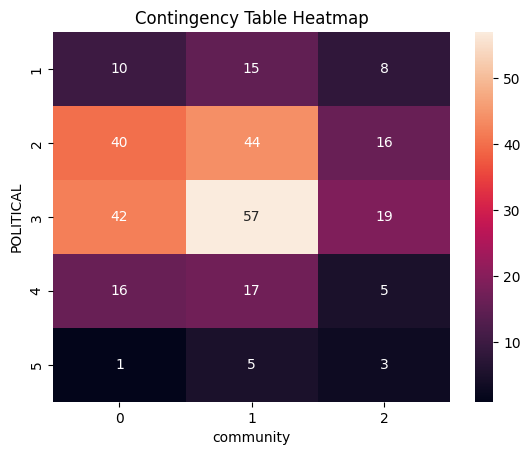

In [55]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a heatmap for the contingency table
sns.heatmap(contingency_table, annot=True, fmt='d')
plt.title("Contingency Table Heatmap")
plt.show()

### Chi-Square test

In [56]:
# Perform the Chi-squared test
chi2, p, dof, expected = stats.chi2_contingency(contingency_table)

# Print the results in a readable format
print(f"{'Chi-Squared Test Results':^40}")
print("="*40)
print(f"{'Test Statistic (Chi2):':<25} {chi2:.4f}")
print(f"{'Degrees of Freedom:':<25} {dof}")
print(f"{'p-value:':<25} {p:.4e}")
print("\nExpected Frequencies (rounded):")
print(pd.DataFrame(expected, 
                   index=contingency_table.index, 
                   columns=contingency_table.columns).round(2))

        Chi-Squared Test Results        
Test Statistic (Chi2):    5.8821
Degrees of Freedom:       8
p-value:                  6.6043e-01

Expected Frequencies (rounded):
community      0      1      2
POLITICAL                     
1          12.07  15.28   5.65
2          36.58  46.31  17.11
3          43.16  54.64  20.19
4          13.90  17.60   6.50
5           3.29   4.17   1.54


* result: no significant difference


### Influence of a label on the chi-square test: residuals calculations

In [57]:
# Calculate the residuals
residuals = contingency_table - expected

# Standardize the residuals
standardized_residuals = residuals / np.sqrt(expected)

# Convert to DataFrame for better readability
standardized_residuals_df = pd.DataFrame(standardized_residuals,
                                         index=contingency_table.index,
                                         columns=contingency_table.columns)

# Print results
print(f"{'Chi-Squared Test Results':^40}")
print("="*40)
print(f"{'Test Statistic (Chi2):':<25} {chi2:.4f}")
print(f"{'Degrees of Freedom:':<25} {dof}")
print(f"{'p-value:':<25} {p:.4e}")
print("\nExpected Frequencies (rounded):")
print(pd.DataFrame(expected, 
                   index=contingency_table.index, 
                   columns=contingency_table.columns).round(2))
print("\nStandardized Residuals:")
print(standardized_residuals_df.round(2))

# Optional: if you want to see which residuals are extreme
print("\nExtreme Standardized Residuals (|value| > 2):")
print(standardized_residuals_df[standardized_residuals_df.abs() > 2].dropna(how='all'))


        Chi-Squared Test Results        
Test Statistic (Chi2):    5.8821
Degrees of Freedom:       8
p-value:                  6.6043e-01

Expected Frequencies (rounded):
community      0      1      2
POLITICAL                     
1          12.07  15.28   5.65
2          36.58  46.31  17.11
3          43.16  54.64  20.19
4          13.90  17.60   6.50
5           3.29   4.17   1.54

Standardized Residuals:
community     0     1     2
POLITICAL                  
1         -0.60 -0.07  0.99
2          0.57 -0.34 -0.27
3         -0.18  0.32 -0.27
4          0.56 -0.14 -0.59
5         -1.26  0.41  1.18

Extreme Standardized Residuals (|value| > 2):
Empty DataFrame
Columns: [0, 1, 2]
Index: []


**Result**:
* The distribution of **political leaning** is not significantly different across the communities.
* There is one extreme standardized residual, Political label 2 on the Community 1, which is overrepresented against the other Political label within the community. 

### Education

In [58]:
community_df

,community,id,AGE,GENDER,EDUCATION,EMPLOYMENT,INCOME,POLITICAL,DAT,CRT2
id,,,,,,,,,,
00278,2,00278,24,1,5,1,3,2,74.104969,3
0068d,1,0068d,74,1,2,7,2,4,79.882640,2
00f13,1,00f13,43,1,4,1,3,3,77.948290,3
01cb6,1,01cb6,56,3,2,8,1,1,78.969095,2
02670,1,02670,25,1,5,1,2,2,83.311323,1
...,...,...,...,...,...,...,...,...,...,...
f92a4,1,f92a4,35,1,5,1,3,3,65.242337,2
f9fd8,0,f9fd8,50,1,4,8,2,2,80.076401,1
fb2a2,1,fb2a2,38,1,2,8,1,3,78.420482,0


In [59]:
# Create a contingency table
contingency_table = pd.crosstab(community_df['EDUCATION'], community_df['community'])

# Perform the Chi-squared test
chi2, p, dof, expected = stats.chi2_contingency(contingency_table)

# Print the results in a readable format
print(f"{'Chi-Squared Test Results':^40}")
print("="*40)
print(f"{'Test Statistic (Chi2):':<25} {chi2:.4f}")
print(f"{'Degrees of Freedom:':<25} {dof}")
print(f"{'p-value:':<25} {p:.4e}")
print("\nExpected Frequencies (rounded):")
print(pd.DataFrame(expected, 
                   index=contingency_table.index, 
                   columns=contingency_table.columns).round(2))

        Chi-Squared Test Results        
Test Statistic (Chi2):    6.7406
Degrees of Freedom:       8
p-value:                  5.6486e-01

Expected Frequencies (rounded):
community      0      1      2
EDUCATION                     
2          28.53  36.12  13.35
3          19.75  25.01   9.24
4          39.50  50.01  18.48
5          20.48  25.93   9.58
6           0.73   0.93   0.34


In [60]:
contingency_table_filtered = contingency_table.loc[[2,3,4,5]]

In [61]:
# Perform the Chi-squared test
chi2, p, dof, expected = stats.chi2_contingency(contingency_table_filtered)

# Print the results in a readable format
print(f"{'Chi-Squared Test Results':^40}")
print("="*40)
print(f"{'Test Statistic (Chi2):':<25} {chi2:.4f}")
print(f"{'Degrees of Freedom:':<25} {dof}")
print(f"{'p-value:':<25} {p:.4e}")
print("\nExpected Frequencies (rounded):")
print(pd.DataFrame(expected, 
                   index=contingency_table_filtered.index, 
                   columns=contingency_table_filtered.columns).round(2))

        Chi-Squared Test Results        
Test Statistic (Chi2):    4.3990
Degrees of Freedom:       6
p-value:                  6.2285e-01

Expected Frequencies (rounded):
community      0      1      2
EDUCATION                     
2          28.72  35.84  13.44
3          19.89  24.81   9.30
4          39.77  49.62  18.61
5          20.62  25.73   9.65


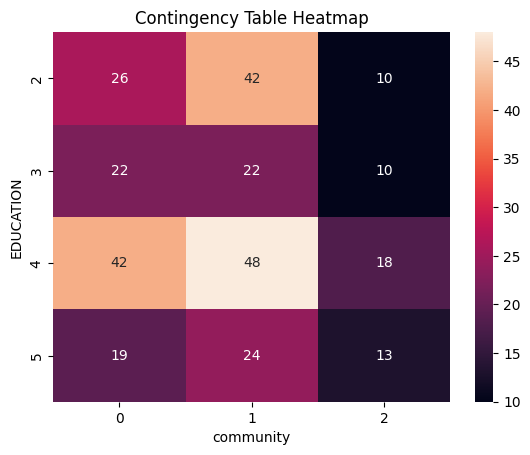

In [62]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a heatmap for the contingency table
sns.heatmap(contingency_table_filtered, annot=True, fmt='d')
plt.title("Contingency Table Heatmap")
plt.show()

**Result**: It says, the educationn shows no significant difference between the clusters

### Influence of a label on the chi-square test: residuals calculations

In [63]:
# Calculate the residuals
residuals = contingency_table_filtered - expected

# Standardize the residuals
standardized_residuals = residuals / np.sqrt(expected)

# Convert to DataFrame for better readability
standardized_residuals_df = pd.DataFrame(standardized_residuals,
                                         index=contingency_table_filtered.index,
                                         columns=contingency_table_filtered.columns)

# Print results
print(f"{'Chi-Squared Test Results':^40}")
print("="*40)
print(f"{'Test Statistic (Chi2):':<25} {chi2:.4f}")
print(f"{'Degrees of Freedom:':<25} {dof}")
print(f"{'p-value:':<25} {p:.4e}")
print("\nExpected Frequencies (rounded):")
print(pd.DataFrame(expected, 
                   index=contingency_table_filtered.index, 
                   columns=contingency_table_filtered.columns).round(2))
print("\nStandardized Residuals:")
print(standardized_residuals_df.round(2))

# Optional: if you want to see which residuals are extreme
print("\nExtreme Standardized Residuals (|value| > 2):")
print(standardized_residuals_df[standardized_residuals_df.abs() > 2].dropna(how='all'))


        Chi-Squared Test Results        
Test Statistic (Chi2):    4.3990
Degrees of Freedom:       6
p-value:                  6.2285e-01

Expected Frequencies (rounded):
community      0      1      2
EDUCATION                     
2          28.72  35.84  13.44
3          19.89  24.81   9.30
4          39.77  49.62  18.61
5          20.62  25.73   9.65

Standardized Residuals:
community     0     1     2
EDUCATION                  
2         -0.51  1.03 -0.94
3          0.47 -0.56  0.23
4          0.35 -0.23 -0.14
5         -0.36 -0.34  1.08

Extreme Standardized Residuals (|value| > 2):
Empty DataFrame
Columns: [0, 1, 2]
Index: []


**Result**
* There is no extreme residuals found between the community 0, 1, 2. 

### Gender

In [64]:
community_df

,community,id,AGE,GENDER,EDUCATION,EMPLOYMENT,INCOME,POLITICAL,DAT,CRT2
id,,,,,,,,,,
00278,2,00278,24,1,5,1,3,2,74.104969,3
0068d,1,0068d,74,1,2,7,2,4,79.882640,2
00f13,1,00f13,43,1,4,1,3,3,77.948290,3
01cb6,1,01cb6,56,3,2,8,1,1,78.969095,2
02670,1,02670,25,1,5,1,2,2,83.311323,1
...,...,...,...,...,...,...,...,...,...,...
f92a4,1,f92a4,35,1,5,1,3,3,65.242337,2
f9fd8,0,f9fd8,50,1,4,8,2,2,80.076401,1
fb2a2,1,fb2a2,38,1,2,8,1,3,78.420482,0


In [65]:
# Create a contingency table
contingency_table = pd.crosstab(community_df['GENDER'], community_df['community'])

# Show the contingency table
print(contingency_table) # it shows the change by the cell. 

community   0   1   2
GENDER               
1          54  71  26
2           0   1   0
3          54  66  25
5           1   0   0


In [66]:
contingency_table

community,0,1,2
GENDER,,,
1,54,71,26
2,0,1,0
3,54,66,25
5,1,0,0


In [67]:
# Perform Chi-Square test
chi2_statistic, p_value, dof, expected = stats.chi2_contingency(contingency_table)

# Print the results
print("Expected Frequencies:")
print(expected)

# Check if all expected frequencies are >= 5
if np.all(expected >= 5):
    print("All expected frequencies are >= 5. The Chi-Square test can be used.")
else:
    print("Some expected frequencies are < 5. Consider using Fisher's Exact Test or combining categories.")

Expected Frequencies:
[[55.23154362 69.9261745  25.84228188]
 [ 0.36577181  0.46308725  0.17114094]
 [53.03691275 67.14765101 24.81543624]
 [ 0.36577181  0.46308725  0.17114094]]
Some expected frequencies are < 5. Consider using Fisher's Exact Test or combining categories.


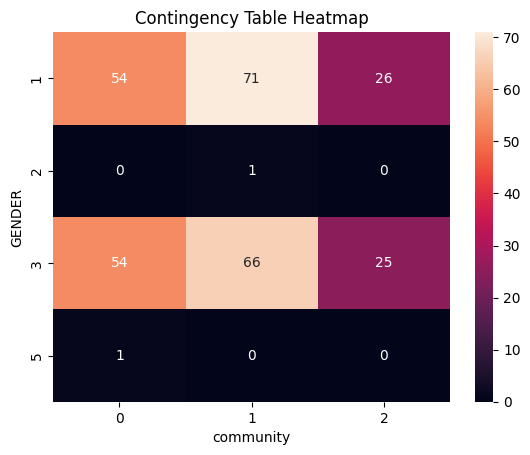

In [68]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a heatmap for the contingency table
sns.heatmap(contingency_table, annot=True, fmt='d')
plt.title("Contingency Table Heatmap")
plt.show()

### Chi-Square test

In [69]:
contingency_table_filtered = contingency_table.loc[[1,3]]

In [70]:
# Perform the Chi-squared test
chi2, p, dof, expected = stats.chi2_contingency(contingency_table_filtered)

# Print the results in a readable format
print(f"{'Chi-Squared Test Results':^40}")
print("="*40)
print(f"{'Test Statistic (Chi2):':<25} {chi2:.4f}")
print(f"{'Degrees of Freedom:':<25} {dof}")
print(f"{'p-value:':<25} {p:.4e}")
print("\nExpected Frequencies (rounded):")
print(pd.DataFrame(expected, 
                   index=contingency_table_filtered.index, 
                   columns=contingency_table_filtered.columns).round(2))

        Chi-Squared Test Results        
Test Statistic (Chi2):    0.0805
Degrees of Freedom:       2
p-value:                  9.6055e-01

Expected Frequencies (rounded):
community      0      1      2
GENDER                        
1          55.09  69.89  26.02
3          52.91  67.11  24.98


* result: no significant difference

### Influence of a label on the chi-square test: residuals calculations

In [71]:
# Calculate the residuals
residuals = contingency_table_filtered - expected

# Standardize the residuals
standardized_residuals = residuals / np.sqrt(expected)

# Convert to DataFrame for better readability
standardized_residuals_df = pd.DataFrame(standardized_residuals,
                                         index=contingency_table_filtered.index,
                                         columns=contingency_table_filtered.columns)

# Print results
print(f"{'Chi-Squared Test Results':^40}")
print("="*40)
print(f"{'Test Statistic (Chi2):':<25} {chi2:.4f}")
print(f"{'Degrees of Freedom:':<25} {dof}")
print(f"{'p-value:':<25} {p:.4e}")
print("\nExpected Frequencies (rounded):")
print(pd.DataFrame(expected, 
                   index=contingency_table_filtered.index, 
                   columns=contingency_table_filtered.columns).round(2))
print("\nStandardized Residuals:")
print(standardized_residuals_df.round(2))

# Optional: if you want to see which residuals are extreme
print("\nExtreme Standardized Residuals (|value| > 2):")
print(standardized_residuals_df[standardized_residuals_df.abs() > 2].dropna(how='all'))


        Chi-Squared Test Results        
Test Statistic (Chi2):    0.0805
Degrees of Freedom:       2
p-value:                  9.6055e-01

Expected Frequencies (rounded):
community      0      1      2
GENDER                        
1          55.09  69.89  26.02
3          52.91  67.11  24.98

Standardized Residuals:
community     0     1    2
GENDER                    
1         -0.15  0.13 -0.0
3          0.15 -0.14  0.0

Extreme Standardized Residuals (|value| > 2):
Empty DataFrame
Columns: [0, 1, 2]
Index: []


**Result:**: 
* Residuals: needs to be filled.

### INCOME

In [72]:
community_df

,community,id,AGE,GENDER,EDUCATION,EMPLOYMENT,INCOME,POLITICAL,DAT,CRT2
id,,,,,,,,,,
00278,2,00278,24,1,5,1,3,2,74.104969,3
0068d,1,0068d,74,1,2,7,2,4,79.882640,2
00f13,1,00f13,43,1,4,1,3,3,77.948290,3
01cb6,1,01cb6,56,3,2,8,1,1,78.969095,2
02670,1,02670,25,1,5,1,2,2,83.311323,1
...,...,...,...,...,...,...,...,...,...,...
f92a4,1,f92a4,35,1,5,1,3,3,65.242337,2
f9fd8,0,f9fd8,50,1,4,8,2,2,80.076401,1
fb2a2,1,fb2a2,38,1,2,8,1,3,78.420482,0


In [73]:
# Create a contingency table
contingency_table = pd.crosstab(community_df['INCOME'], community_df['community'])

# Show the contingency table
print(contingency_table) # it shows the change by the cell. 

community   0   1   2
INCOME               
1          25  37  12
2          38  55  21
3          24  27   8
4          17  15   8
5           5   4   2


In [74]:
contingency_table

community,0,1,2
INCOME,,,
1,25,37,12
2,38,55,21
3,24,27,8
4,17,15,8
5,5,4,2


In [75]:
# Perform Chi-Square test
chi2_statistic, p_value, dof, expected = stats.chi2_contingency(contingency_table)

# Print the results
print("Expected Frequencies:")
print(expected)

# Check if all expected frequencies are >= 5
if np.all(expected >= 5):
    print("All expected frequencies are >= 5. The Chi-Square test can be used.")
else:
    print("Some expected frequencies are < 5. Consider using Fisher's Exact Test or combining categories.")

Expected Frequencies:
[[27.06711409 34.26845638 12.66442953]
 [41.69798658 52.79194631 19.51006711]
 [21.58053691 27.32214765 10.09731544]
 [14.63087248 18.52348993  6.84563758]
 [ 4.02348993  5.09395973  1.88255034]]
Some expected frequencies are < 5. Consider using Fisher's Exact Test or combining categories.


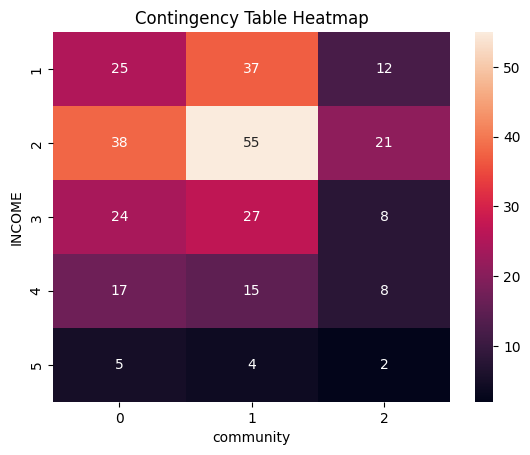

In [76]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a heatmap for the contingency table
sns.heatmap(contingency_table, annot=True, fmt='d')
plt.title("Contingency Table Heatmap")
plt.show()

### Chi-Square test

In [77]:
# Perform the Chi-squared test
chi2, p, dof, expected = stats.chi2_contingency(contingency_table)

# Print the results in a readable format
print(f"{'Chi-Squared Test Results':^40}")
print("="*40)
print(f"{'Test Statistic (Chi2):':<25} {chi2:.4f}")
print(f"{'Degrees of Freedom:':<25} {dof}")
print(f"{'p-value:':<25} {p:.4e}")
print("\nExpected Frequencies (rounded):")
print(pd.DataFrame(expected, 
                   index=contingency_table.index, 
                   columns=contingency_table.columns).round(2))

        Chi-Squared Test Results        
Test Statistic (Chi2):    3.3830
Degrees of Freedom:       8
p-value:                  9.0808e-01

Expected Frequencies (rounded):
community      0      1      2
INCOME                        
1          27.07  34.27  12.66
2          41.70  52.79  19.51
3          21.58  27.32  10.10
4          14.63  18.52   6.85
5           4.02   5.09   1.88


* result: no significant difference

### Influence of a label on the chi-square test: residuals calculations

In [78]:
# Calculate the residuals
residuals = contingency_table - expected

# Standardize the residuals
standardized_residuals = residuals / np.sqrt(expected)

# Convert to DataFrame for better readability
standardized_residuals_df = pd.DataFrame(standardized_residuals,
                                         index=contingency_table.index,
                                         columns=contingency_table.columns)

# Print results
print(f"{'Chi-Squared Test Results':^40}")
print("="*40)
print(f"{'Test Statistic (Chi2):':<25} {chi2:.4f}")
print(f"{'Degrees of Freedom:':<25} {dof}")
print(f"{'p-value:':<25} {p:.4e}")
print("\nExpected Frequencies (rounded):")
print(pd.DataFrame(expected, 
                   index=contingency_table.index, 
                   columns=contingency_table.columns).round(2))
print("\nStandardized Residuals:")
print(standardized_residuals_df.round(2))

# Optional: if you want to see which residuals are extreme
print("\nExtreme Standardized Residuals (|value| > 2):")
print(standardized_residuals_df[standardized_residuals_df.abs() > 2].dropna(how='all'))


        Chi-Squared Test Results        
Test Statistic (Chi2):    3.3830
Degrees of Freedom:       8
p-value:                  9.0808e-01

Expected Frequencies (rounded):
community      0      1      2
INCOME                        
1          27.07  34.27  12.66
2          41.70  52.79  19.51
3          21.58  27.32  10.10
4          14.63  18.52   6.85
5           4.02   5.09   1.88

Standardized Residuals:
community     0     1     2
INCOME                     
1         -0.40  0.47 -0.19
2         -0.57  0.30  0.34
3          0.52 -0.06 -0.66
4          0.62 -0.82  0.44
5          0.49 -0.48  0.09

Extreme Standardized Residuals (|value| > 2):
Empty DataFrame
Columns: [0, 1, 2]
Index: []


### Employment

In [79]:
community_df

,community,id,AGE,GENDER,EDUCATION,EMPLOYMENT,INCOME,POLITICAL,DAT,CRT2
id,,,,,,,,,,
00278,2,00278,24,1,5,1,3,2,74.104969,3
0068d,1,0068d,74,1,2,7,2,4,79.882640,2
00f13,1,00f13,43,1,4,1,3,3,77.948290,3
01cb6,1,01cb6,56,3,2,8,1,1,78.969095,2
02670,1,02670,25,1,5,1,2,2,83.311323,1
...,...,...,...,...,...,...,...,...,...,...
f92a4,1,f92a4,35,1,5,1,3,3,65.242337,2
f9fd8,0,f9fd8,50,1,4,8,2,2,80.076401,1
fb2a2,1,fb2a2,38,1,2,8,1,3,78.420482,0


In [80]:
# Create a contingency table
contingency_table = pd.crosstab(community_df['EMPLOYMENT'], community_df['community'])

# Show the contingency table
print(contingency_table) # it shows the change by the cell. 

community    0   1   2
EMPLOYMENT            
1           41  55  14
2           20  12   9
3            3   5   5
4           12  22   9
5            5   7   4
6            7   7   4
7           16  22   4
8            5   8   2


In [81]:
contingency_table

community,0,1,2
EMPLOYMENT,,,
1,41,55,14
2,20,12,9
3,3,5,5
4,12,22,9
5,5,7,4
6,7,7,4
7,16,22,4
8,5,8,2


In [82]:
# Perform Chi-Square test
chi2_statistic, p_value, dof, expected = stats.chi2_contingency(contingency_table)

# Print the results
print("Expected Frequencies:")
print(expected)

# Check if all expected frequencies are >= 5
if np.all(expected >= 5):
    print("All expected frequencies are >= 5. The Chi-Square test can be used.")
else:
    print("Some expected frequencies are < 5. Consider using Fisher's Exact Test or combining categories.")

Expected Frequencies:
[[40.23489933 50.93959732 18.82550336]
 [14.9966443  18.98657718  7.01677852]
 [ 4.75503356  6.02013423  2.22483221]
 [15.72818792 19.91275168  7.3590604 ]
 [ 5.85234899  7.40939597  2.73825503]
 [ 6.58389262  8.33557047  3.08053691]
 [15.36241611 19.44966443  7.18791946]
 [ 5.48657718  6.94630872  2.56711409]]
Some expected frequencies are < 5. Consider using Fisher's Exact Test or combining categories.


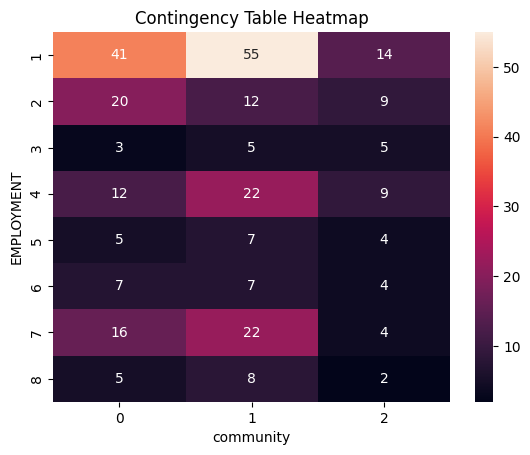

In [83]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a heatmap for the contingency table
sns.heatmap(contingency_table, annot=True, fmt='d')
plt.title("Contingency Table Heatmap")
plt.show()

### Chi-Square test

In [85]:
# Perform the Chi-squared test
chi2, p, dof, expected = stats.chi2_contingency(contingency_table)

# Print the results in a readable format
print(f"{'Chi-Squared Test Results':^40}")
print("="*40)
print(f"{'Test Statistic (Chi2):':<25} {chi2:.4f}")
print(f"{'Degrees of Freedom:':<25} {dof}")
print(f"{'p-value:':<25} {p:.4e}")
print("\nExpected Frequencies (rounded):")
print(pd.DataFrame(expected, 
                   index=contingency_table.index, 
                   columns=contingency_table.columns).round(2))

        Chi-Squared Test Results        
Test Statistic (Chi2):    15.4724
Degrees of Freedom:       14
p-value:                  3.4664e-01

Expected Frequencies (rounded):
community       0      1      2
EMPLOYMENT                     
1           40.23  50.94  18.83
2           15.00  18.99   7.02
3            4.76   6.02   2.22
4           15.73  19.91   7.36
5            5.85   7.41   2.74
6            6.58   8.34   3.08
7           15.36  19.45   7.19
8            5.49   6.95   2.57


* result: no significant difference

### Influence of a label on the chi-square test: residuals calculations

In [86]:
# Calculate the residuals
residuals = contingency_table - expected

# Standardize the residuals
standardized_residuals = residuals / np.sqrt(expected)

# Convert to DataFrame for better readability
standardized_residuals_df = pd.DataFrame(standardized_residuals,
                                         index=contingency_table.index,
                                         columns=contingency_table.columns)

# Print results
print(f"{'Chi-Squared Test Results':^40}")
print("="*40)
print(f"{'Test Statistic (Chi2):':<25} {chi2:.4f}")
print(f"{'Degrees of Freedom:':<25} {dof}")
print(f"{'p-value:':<25} {p:.4e}")
print("\nExpected Frequencies (rounded):")
print(pd.DataFrame(expected, 
                   index=contingency_table.index, 
                   columns=contingency_table.columns).round(2))
print("\nStandardized Residuals:")
print(standardized_residuals_df.round(2))

# Optional: if you want to see which residuals are extreme
print("\nExtreme Standardized Residuals (|value| > 2):")
print(standardized_residuals_df[standardized_residuals_df.abs() > 2].dropna(how='all'))


        Chi-Squared Test Results        
Test Statistic (Chi2):    15.4724
Degrees of Freedom:       14
p-value:                  3.4664e-01

Expected Frequencies (rounded):
community       0      1      2
EMPLOYMENT                     
1           40.23  50.94  18.83
2           15.00  18.99   7.02
3            4.76   6.02   2.22
4           15.73  19.91   7.36
5            5.85   7.41   2.74
6            6.58   8.34   3.08
7           15.36  19.45   7.19
8            5.49   6.95   2.57

Standardized Residuals:
community      0     1     2
EMPLOYMENT                  
1           0.12  0.57 -1.11
2           1.29 -1.60  0.75
3          -0.80 -0.42  1.86
4          -0.94  0.47  0.60
5          -0.35 -0.15  0.76
6           0.16 -0.46  0.52
7           0.16  0.58 -1.19
8          -0.21  0.40 -0.35

Extreme Standardized Residuals (|value| > 2):
Empty DataFrame
Columns: [0, 1, 2]
Index: []


**Result**: 
Residuals: needs to be filled.

## 2. Dataset: responses stacked

In [339]:
# dataset
q2 = pd.read_json('~/thesis/data/processed_data/knowledge_q2_lemmatized.jsonl', orient='records', lines = True)

In [340]:
q2.head()

,participant_id,answer
0,00278,equal pay woman men role
1,00278,ensure woman voice heard
2,00278,woman equally considered promotion
3,00278,education sexual harassment
4,00278,woman seen equal men capable


In [341]:
# Step 4: Vectorize the concatenated responses using BoW
vectorizer = CountVectorizer(max_features=1000)
vectors2 = vectorizer.fit_transform(q2['answer']).toarray()

In [342]:
# Step 5: Create a DataFrame from the vectors
final_df = pd.DataFrame(vectors2, index=q2['participant_id'])

In [343]:
# Step 6: Convert final_df to a Gensim-compatible corpus format
corpus = [list(enumerate(doc)) for doc in final_df.values]

# Create a Gensim Dictionary using the vocabulary from the vectorizer
vocab = vectorizer.get_feature_names_out()
dummy_dict = corpora.Dictionary()
dummy_dict.token2id = {word: idx for idx, word in enumerate(vocab)}
dummy_dict.id2token = {idx: word for idx, word in enumerate(vocab)}

## Coherence Score to define num_topics parameter

In [344]:
from gensim.models import CoherenceModel

### warning: it takes long. Just be sure you need it.

In [346]:
# Function to compute coherence score
def compute_coherence_score(corpus, dictionary, texts, num_topics):
    lda_model = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary, passes=10)
    coherence_model = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
    return coherence_model.get_coherence()

# Prepare texts for coherence computation
texts = [doc.split() for doc in q2['answer']]  # Assuming you have preprocessed texts

# Evaluate coherence score for different numbers of topics
num_topics_list = range(2, 15)
coherence_scores = []

for num_topics in num_topics_list:
    coherence_score = compute_coherence_score(corpus, dummy_dict, texts, num_topics)
    coherence_scores.append(coherence_score)
    print(f'Number of topics: {num_topics}, Coherence Score: {coherence_score}')



Number of topics: 2, Coherence Score: 0.3149387775569541
Number of topics: 3, Coherence Score: 0.4632692806483149
Number of topics: 4, Coherence Score: 0.42918511243916935
Number of topics: 5, Coherence Score: 0.43334328646658465
Number of topics: 6, Coherence Score: 0.4885907040266282
Number of topics: 7, Coherence Score: 0.4740040613206956
Number of topics: 8, Coherence Score: 0.44143631683568285
Number of topics: 9, Coherence Score: 0.46240943676057356
Number of topics: 10, Coherence Score: 0.4743713374965914
Number of topics: 11, Coherence Score: 0.4834824361979408
Number of topics: 12, Coherence Score: 0.5049459221264142
Number of topics: 13, Coherence Score: 0.48797393950491574
Number of topics: 14, Coherence Score: 0.49671518067332227


In [ ]:
import matplotlib.pyplot as plt

In [ ]:
# Plot coherence scores
plt.figure(figsize=(10, 5))
plt.plot(num_topics_list, coherence_scores, marker='o')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.title('Coherence Score vs. Number of Topics')
plt.show()


In [ ]:
# Step 7: Train the LDA model on the corpus
num_topics = 9  # Adjust based on your needs
lda_model = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dummy_dict, passes=10)

In [ ]:
# Step 8: Visualize the LDA Model using PyLDAvis
pyLDAvis.enable_notebook()
LDAvis_data_filepath = os.path.join('/mnt/home/kim/thesis/lda-figure/mpib/ldavis_'+str(num_topics))

# Prepare the visualization
if not os.path.exists(LDAvis_data_filepath):
    LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, corpus, dummy_dict)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)
else:
    with open(LDAvis_data_filepath, 'rb') as f:
        LDAvis_prepared = pickle.load(f)

# Save the visualization as an HTML file
pyLDAvis.save_html(LDAvis_prepared, '/mnt/home/kim/thesis/lda-figure/mpib/ldavis_'+str(num_topics)+'.html')

# Display the visualization inline (in Jupyter Notebook)
LDAvis_prepared


## Additional: 

In [79]:
from gensim.utils import simple_preprocess
from collections import Counter
from itertools import combinations
import pickle

In [80]:
# Extract top words for each topic
top_words_per_topic = []
for t in range(num_topics):
    top_words = [word for word, _ in lda_model.show_topic(t, topn=20)]
    top_words_per_topic.append(top_words)

In [81]:
top_words_per_topic

[['gender',
  'promotion',
  'salary',
  'company',
  'equal',
  'woman',
  'opportunity',
  'treat',
  'role',
  'give',
  'everyone',
  'regardless',
  'increase',
  'respect',
  'number',
  'encourage',
  'make',
  'ensure',
  'discussion',
  'equally'],
 ['people',
  'female',
  'male',
  'place',
  'gender',
  'leave',
  'policy',
  'number',
  'ensure',
  'employ',
  'higher',
  'equality',
  'training',
  'workplace',
  'equal',
  'review',
  'inequality',
  'parental',
  'employee',
  'position'],
 ['work',
  'gender',
  'training',
  'flexible',
  'child',
  'woman',
  'encourage',
  'allow',
  'group',
  'people',
  'sexism',
  'support',
  'working',
  'care',
  'incentive',
  'workplace',
  'equal',
  'offer',
  'issue',
  'diversity'],
 ['gender',
  'equality',
  'discrimination',
  'job',
  'role',
  'employee',
  'educate',
  'improve',
  'people',
  'work',
  'dont',
  'equal',
  'open',
  'application',
  'toilet',
  'ask',
  'workplace',
  'workshop',
  'specific',
  

In [82]:
# Compute co-occurrence matrix
def compute_cooccurrence_matrix(texts):
    word_counts = Counter(word for text in texts for word in text)
    total_count = sum(word_counts.values())
    word_pairs = Counter()
    for text in texts:
        for i, j in combinations(set(text), 2):
            word_pairs[tuple(sorted([i, j]))] += 1
    return word_pairs, word_counts, total_count

word_pairs, word_counts, total_count = compute_cooccurrence_matrix(data_words)

# Compute NPMI
def compute_npmi(word_pairs, word_counts, total_count):
    npmi_matrix = {}
    for (w_i, w_j), cooccur_count in word_pairs.items():
        p_i = word_counts[w_i] / total_count
        p_j = word_counts[w_j] / total_count
        p_ij = cooccur_count / total_count
        if p_ij > 0:
            pmi = np.log(p_ij / (p_i * p_j))
            npmi = pmi / -np.log(p_ij)
            npmi_matrix[(w_i, w_j)] = npmi
    return npmi_matrix

npmi_matrix = compute_npmi(word_pairs, word_counts, total_count)

In [83]:
# Calculate average NPMI for each topic
def average_npmi_for_topics(top_words_per_topic, npmi_matrix):
    topic_npmis = []
    for top_words in top_words_per_topic:
        npmis = [npmi_matrix.get(tuple(sorted([w_i, w_j])), 0) for w_i, w_j in combinations(top_words, 2)]
        if npmis:
            topic_npmi = np.mean(npmis)
            topic_npmis.append(topic_npmi)
    return np.mean(topic_npmis) if topic_npmis else 0

average_npmi = average_npmi_for_topics(top_words_per_topic, npmi_matrix)
print("Average NPMI for LDA topics:", average_npmi)

Average NPMI for LDA topics: 0.1430087968618129


**Interpretation**

High NPMI (close to 1): Indicates strong semantic coherence between words, meaning the words are likely to appear together in similar contexts. This is generally considered good for topics generated by models like LDA.

NPMI around 0: Indicates that the words appear together about as frequently as expected by chance, suggesting neutral association.

Low NPMI (negative values): Indicates that the words are unlikely to appear together, suggesting poor coherence for the topic.